In [4]:
# %%
import os

cache_dir = '/scratch/hakeem.at/Queryable-Shared-Reference-Repository/notebooks/pretrained_models'

os.environ['HF_HOME'] = cache_dir
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HUGGINGFACE_HUB_CACHE'] = cache_dir

import warnings
import logging
import os
import sys
from contextlib import contextmanager

warnings.filterwarnings("ignore")
os.environ['PYTHONWARNINGS'] = 'ignore'

logging.getLogger("docling").setLevel(logging.ERROR)
logging.getLogger("docling.backend").setLevel(logging.ERROR)
logging.getLogger("docling.datamodel").setLevel(logging.ERROR)
logging.getLogger("docling_parse").setLevel(logging.ERROR)
logging.getLogger("PIL").setLevel(logging.ERROR)
logging.getLogger("pdfplumber").setLevel(logging.ERROR)
logging.getLogger("pdfminer").setLevel(logging.ERROR)

for logger_name in logging.Logger.manager.loggerDict.keys():
    if 'docling' in logger_name.lower() or 'pdf' in logger_name.lower():
        logging.getLogger(logger_name).setLevel(logging.CRITICAL)

@contextmanager
def suppress_stdout_stderr():
    """Suppress all output to stdout and stderr."""
    null_file = open(os.devnull, 'w')
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    sys.stdout = null_file
    sys.stderr = null_file
    try:
        yield
    finally:
        sys.stdout = old_stdout
        sys.stderr = old_stderr
        null_file.close()

# %%
import os
import time
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd
import json
import random
from tqdm.auto import tqdm

from langchain.embeddings.base import Embeddings
from langchain_community.vectorstores import FAISS

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, CrossEncoder

# %%
from docling_core.types.doc.document import DoclingDocument
from docling.chunking import HybridChunker
from docling_core.transforms.chunker.tokenizer.huggingface import HuggingFaceTokenizer

# %%
import torch
import gc

In [5]:
def clear_gpu(*items):
    for item in items:
        del item
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.synchronize()

# %%
seed = 42
random.seed(seed)

# %%
class EmbeddingGemmaEmbeddings(Embeddings):
    def __init__(self, model_id='google/embeddinggemma-300m', device="cuda", batch_size=32, max_seq_length=512):
        self.model = SentenceTransformer(model_id, device=device)
        self.model.max_seq_length = max_seq_length
        self.batch_size = batch_size
        self.tokenizer = self.model.tokenizer
    
    def embed_documents(self, texts, prompt_name="Retrieval-document"):
        embeddings = self.model.encode(
            texts,
            prompt_name=prompt_name,
            batch_size=self.batch_size,
            convert_to_tensor=True
        )
        return embeddings.cpu().numpy().tolist()
    
    def embed_query(self, text):
        embedding = self.model.encode(
            [text],
            prompt_name="Retrieval-query",
            convert_to_tensor=True
        )
        return embedding.cpu().numpy().tolist()[0]

In [6]:
# Add GTE Multilingual Reranker
class GTEReranker:
    """Reranker using Alibaba GTE multilingual reranker"""
    def __init__(self, model_id='Alibaba-NLP/gte-multilingual-reranker-base', device="cuda"):
        from transformers import AutoModelForSequenceClassification, AutoTokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_id,
            trust_remote_code=True,
            torch_dtype=torch.float16
        )
        self.model.to(device)
        self.model.eval()
        self.device = device
    
    def rerank(self, query, documents, top_k=5):
        """
        Rerank documents using GTE reranker
        Returns: List of (document, score) tuples sorted by relevance
        """
        pairs = [[query, doc] for doc in documents]
        
        with torch.no_grad():
            inputs = self.tokenizer(
                pairs, 
                padding=True, 
                truncation=True, 
                return_tensors='pt', 
                max_length=8192
            ).to(self.device)
            scores = self.model(**inputs, return_dict=True).logits.view(-1,).float()
            scores = scores.cpu().numpy()
        
        ranked_indices = np.argsort(scores)[::-1][:top_k]
        reranked_docs = [(documents[idx], float(scores[idx])) for idx in ranked_indices]
        return reranked_docs


In [7]:
# %%
# Load evaluation dataset
eval_qa_dataset_path = "eval_qa_data.json"

with open(eval_qa_dataset_path, "r") as f:
    eval_qa_dataset = json.load(f)

# %%
# Filter out empty datapoints
filtered_eval_qa_dataset = []
count = 0
for qa in eval_qa_dataset:
    if set(qa["question"].lower().strip().split()) and set(qa["excerpt"].lower().strip().split()):
        filtered_eval_qa_dataset.append(qa)
    else:
        count += 1
print(f"Found {count} empty datapoints")

# %%
ground_truth_docs = []
for qa in filtered_eval_qa_dataset:
    excerpt = set(qa["excerpt"].lower().strip().split())
    if excerpt:
        ground_truth_docs.append(excerpt)

queries = [qa["question"] for qa in filtered_eval_qa_dataset]

# %%
def retrieval_metrics(retrieved_docs_list, ground_truth_docs, hit_rate_threshold=0.5, mrr_threshold=0.3):
    ious = []
    precisions = []
    recalls = []
    hits = []
    mrrs = []
    flattened_retrieved_docs = []
    
    for retrieved_docs in retrieved_docs_list:
        flattened_retrieved_doc = set()
        for retrieved_doc in retrieved_docs:
            doc = set(retrieved_doc.lower().strip().split())
            flattened_retrieved_doc.update(doc)
        flattened_retrieved_docs.append(flattened_retrieved_doc)

    for retrieved_docs, retrieved_doc, ground_truth_doc in zip(retrieved_docs_list, flattened_retrieved_docs, ground_truth_docs):
        intersection = len(retrieved_doc & ground_truth_doc)
        union = len(retrieved_doc | ground_truth_doc)
        iou = intersection / union if union > 0 else 0
        precision = intersection / len(retrieved_doc) if len(retrieved_doc) > 0 else 0
        recall = intersection / len(ground_truth_doc) if len(ground_truth_doc) > 0 else 0

        hit = 0
        if recall >= hit_rate_threshold:
            hit = 1
        
        mrr = 0
        for rank, doc in enumerate(retrieved_docs, start=1):
            doc = set(doc.lower().strip().split())
            overlap = len(doc & ground_truth_doc) / len(ground_truth_doc) if len(ground_truth_doc) > 0 else 0
            if overlap >= mrr_threshold:
                mrr = 1.0 / rank
                break
        
        ious.append(iou)
        precisions.append(precision)
        recalls.append(recall)
        hits.append(hit)
        mrrs.append(mrr)
    
    return {
        'recall_mean': np.mean(recalls),
        'recall_std': np.std(recalls),
        'precision_mean': np.mean(precisions),
        'precision_std': np.std(precisions),
        'iou_mean': np.mean(ious),
        'iou_std': np.std(ious),
        'hit_rate': np.mean(hits),
        'mrr_mean': np.mean(mrrs),
        'mrr_std': np.std(mrrs)
    }

# %%
# Load preprocessed documents
output_file = "docling_processed_text.jsonl"
loaded_docs = []
print("Loading preprocessed documents...")
with open(output_file, "r") as f:
    for line in tqdm(f):
        doc = json.loads(line)
        doc = DoclingDocument.model_validate(doc)
        loaded_docs.append(doc)

print(f"Loaded {len(loaded_docs)} documents")

Found 32 empty datapoints
Loading preprocessed documents...


0it [00:00, ?it/s]

Loaded 249 documents


In [8]:
# %%
# Initialize Gemma embeddings with 2048 max length
print("\n=== Initializing Gemma Embeddings (2048 tokens) ===")
embedding_model = EmbeddingGemmaEmbeddings(max_seq_length=2048)
tokenizer = HuggingFaceTokenizer(
    tokenizer=embedding_model.tokenizer,
    max_tokens=2048
)

# %%
# Chunk documents using Hybrid strategy
print("\n=== Chunking Documents (Hybrid Strategy) ===")
chunker = HybridChunker(merge_peers=True, tokenizer=tokenizer)
chunked_datas = []
metadatas = []

start_time = time.time()
for doc_idx, doc in enumerate(tqdm(loaded_docs, desc="Chunking")):
    try:
        chunks = chunker.chunk(dl_doc=doc)
        chunks = [chunker.contextualize(chunk) for chunk in chunks]
        chunked_datas.extend(chunks)
        metadatas.extend([{"chunk_id": f"{doc_idx}_hybrid_{chunk_idx}", "doc_idx": doc_idx} 
                         for chunk_idx in range(len(chunks))])
    except Exception as e:
        print(f"Chunking error for doc {doc_idx}: {str(e)}")

chunking_time = time.time() - start_time
print(f"⏱️ Chunking: {chunking_time:.2f}s | Chunks: {len(chunked_datas)}")


=== Initializing Gemma Embeddings (2048 tokens) ===

=== Chunking Documents (Hybrid Strategy) ===


Chunking:   0%|          | 0/249 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2820 > 2048). Running this sequence through the model will result in indexing errors


⏱️ Chunking: 131.80s | Chunks: 6124


In [9]:
# # %%
# Create embeddings and FAISS index
print("\n=== Creating FAISS Index ===")
start_time = time.time()
vector_store = FAISS.from_texts(chunked_datas, embedding_model, metadatas=metadatas)
embedding_time = time.time() - start_time
print(f"⏱️ Embedding + FAISS indexing: {embedding_time:.2f}s")

# %%
# Encode queries
print("\n=== Encoding Queries ===")
start_time = time.time()
query_embeddings = embedding_model.embed_documents(queries, prompt_name="Retrieval-query")
query_encoding_time = time.time() - start_time
print(f"⏱️ Query encoding: {query_encoding_time:.2f}s")

# %%
# Initial retrieval (retrieve more documents for reranking)
INITIAL_K = 30  # Common practice: 20-50 documents
FINAL_K = 5     # Final number after reranking

print(f"\n=== Initial Retrieval (k={INITIAL_K}) ===")
semantic_retrieved_docs = []
semantic_retrieved_scores = []
initial_retrieval_time_start = time.time()

for query_idx, query_embedding in enumerate(tqdm(query_embeddings, desc="Initial retrieval")):
    retrieved_docs_with_scores = vector_store.similarity_search_with_score_by_vector(query_embedding, k=INITIAL_K)
    semantic_retrieved_doc = [doc.page_content for doc, score in retrieved_docs_with_scores]
    semantic_retrieved_score = [score for doc, score in retrieved_docs_with_scores]
    semantic_retrieved_docs.append(semantic_retrieved_doc)
    semantic_retrieved_scores.append(semantic_retrieved_score)
    

initial_retrieval_time = time.time() - initial_retrieval_time_start
print(f"⏱️ Initial retrieval: {initial_retrieval_time:.2f}s")

# %%
# Baseline: No reranking (just top 5 from initial retrieval)
print("\n=== Baseline: No Reranking (Top 5) ===")
baseline_retrieved = [docs[:FINAL_K] for docs in semantic_retrieved_docs]

start_time = time.time()
baseline_metrics = retrieval_metrics(baseline_retrieved, ground_truth_docs)
metrics_time = time.time() - start_time

print(f"⏱️ Metrics computation: {metrics_time:.2f}s")
print("\nBaseline Metrics:")
for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")


=== Creating FAISS Index ===
⏱️ Embedding + FAISS indexing: 219.99s

=== Encoding Queries ===
⏱️ Query encoding: 1.13s

=== Initial Retrieval (k=30) ===


Initial retrieval:   0%|          | 0/723 [00:00<?, ?it/s]

⏱️ Initial retrieval: 1.21s

=== Baseline: No Reranking (Top 5) ===
⏱️ Metrics computation: 0.40s

Baseline Metrics:
  recall_mean: 0.6551
  recall_std: 0.2992
  precision_mean: 0.0255
  precision_std: 0.0291
  iou_mean: 0.0249
  iou_std: 0.0286
  hit_rate: 0.7012
  mrr_mean: 0.6850
  mrr_std: 0.4131


### Keyword Retrieval

In [10]:
import bm25s, Stemmer

In [11]:
class BM25Retriever:
    def __init__(self,):
        self.retriever = None
        self.corpus = []
        self.chunk_ids = []
        self.stemmer = Stemmer.Stemmer("english")

    def index(self, chunks):
        self.corpus = chunks
        self.chunk_ids = [id for id in range(len(chunks))]

        corpus_tokens = bm25s.tokenize(self.corpus,
                                       stopwords="en",
                                       stemmer = self.stemmer)

        self.retriever = bm25s.BM25(corpus = self.corpus)
        self.retriever.index(corpus_tokens)

    def search(self, query, k=30):
        query_tokens = bm25s.tokenize(query,
                                       stopwords="en",
                                       stemmer = self.stemmer)

        results = self.retriever.retrieve(query_tokens, k=k)
        chunks = results.documents.tolist()[0]
        scores = results.scores.tolist()[0]
        return chunks, scores

In [12]:
bm25_retriever = BM25Retriever()

In [13]:
start_time = time.time()
bm25_retriever.index(chunked_datas)
embedding_time = time.time() - start_time
print(f"⏱️ BM25 indexing: {embedding_time:.2f}s")

Split strings:   0%|          | 0/6124 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/6124 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/6124 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/6124 [00:00<?, ?it/s]

⏱️ BM25 indexing: 1.81s


In [14]:
query = "What's the name of the imaging used prominently for protein analysis?"
start_time = time.time()
chunks, scores = bm25_retriever.search(query)
print(f"⏱️ BM25 retrieval: {embedding_time:.2f}s")

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏱️ BM25 retrieval: 1.81s


In [15]:
# Initial retrieval (retrieve more documents for reranking)
INITIAL_K = 30  # Common practice: 20-50 documents
FINAL_K = 5     # Final number after reranking

print(f"\n=== Initial Retrieval (k={INITIAL_K}) ===")
bm25_retrieved_docs = []
bm25_retrieved_scores = []
initial_retrieval_time_start = time.time()

for query_idx, query in enumerate(tqdm(queries, desc="Initial retrieval")):
    retrieved_docs, scores = bm25_retriever.search(query, k=INITIAL_K)
    bm25_retrieved_docs.append(retrieved_docs)
    bm25_retrieved_scores.append(scores)
    

initial_retrieval_time = time.time() - initial_retrieval_time_start
print(f"⏱️ Initial retrieval: {initial_retrieval_time:.2f}s")

# Baseline: No reranking (just top 5 from initial retrieval)
print("\n=== Baseline: No Reranking (Top 5) ===")
baseline_retrieved = [docs[:FINAL_K] for docs in bm25_retrieved_docs]

start_time = time.time()
baseline_metrics = retrieval_metrics(baseline_retrieved, ground_truth_docs)
metrics_time = time.time() - start_time


=== Initial Retrieval (k=30) ===


Initial retrieval:   0%|          | 0/723 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:01<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏱️ Initial retrieval: 19.47s

=== Baseline: No Reranking (Top 5) ===


In [16]:
print(f"⏱️ Metrics computation: {metrics_time:.2f}s")
print("\nBaseline Metrics:")
for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")

⏱️ Metrics computation: 0.58s

Baseline Metrics:
  recall_mean: 0.7800
  recall_std: 0.2641
  precision_mean: 0.0213
  precision_std: 0.0236
  iou_mean: 0.0211
  iou_std: 0.0235
  hit_rate: 0.8423
  mrr_mean: 0.8281
  mrr_std: 0.3439


### Semantic + BM25

In [17]:
FINAL_K//2+1

3

In [18]:
# Initial retrieval (retrieve more documents for reranking)
INITIAL_K = 30  # Common practice: 20-50 documents
FINAL_K = 5     # Final number after reranking

print(f"\n=== Initial Retrieval (k={INITIAL_K}) ===")
retrieved_docs = []
initial_retrieval_time_start = time.time()

for query_idx, query in enumerate(tqdm(queries, desc="Initial retrieval")):
    initial_docs = semantic_retrieved_docs[query_idx][:FINAL_K//2+1] + bm25_retrieved_docs[query_idx][:FINAL_K//2+1]
    retrieved_docs.append(initial_docs)
    

initial_retrieval_time = time.time() - initial_retrieval_time_start
print(f"⏱️ Initial retrieval: {initial_retrieval_time:.2f}s")

# Baseline: No reranking (just top 5 from initial retrieval)
print("\n=== Baseline: Semantic + BM25===")

start_time = time.time()
baseline_metrics = retrieval_metrics(retrieved_docs, ground_truth_docs)
metrics_time = time.time() - start_time


=== Initial Retrieval (k=30) ===


Initial retrieval:   0%|          | 0/723 [00:00<?, ?it/s]

⏱️ Initial retrieval: 0.01s

=== Baseline: Semantic + BM25===


In [19]:
print(f"⏱️ Metrics computation: {metrics_time:.2f}s")
print("Metrics:")
for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")

⏱️ Metrics computation: 0.50s
Metrics:
  recall_mean: 0.7773
  recall_std: 0.2613
  precision_mean: 0.0244
  precision_std: 0.0283
  iou_mean: 0.0241
  iou_std: 0.0273
  hit_rate: 0.8423
  mrr_mean: 0.7055
  mrr_std: 0.3836


### Reranker Impact

In [13]:
gte_reranker = GTEReranker()

gte_reranked_docs = []
gte_reranking_time_start = time.time()

for query_idx, query in enumerate(tqdm(queries, desc="GTE reranking")):
    initial_docs = bm25_retrieved_docs[query_idx]
    reranked = gte_reranker.rerank(query, initial_docs, top_k=FINAL_K)
    reranked_docs = [doc for doc, score in reranked]
    gte_reranked_docs.append(reranked_docs)

gte_reranking_time = time.time() - gte_reranking_time_start
print(f"GTE reranking: {gte_reranking_time:.2f}s")

start_time = time.time()
gte_metrics = retrieval_metrics(gte_reranked_docs, ground_truth_docs)
metrics_time = time.time() - start_time

print(f"Metrics computation: {metrics_time:.2f}s")
print("\nBM25 + GTE Reranking Metrics:")
for metric, value in gte_metrics.items():
    print(f"  {metric}: {value:.4f}")

`torch_dtype` is deprecated! Use `dtype` instead!


GTE reranking:   0%|          | 0/723 [00:00<?, ?it/s]

GTE reranking: 429.91s
Metrics computation: 0.49s

BM25 + GTE Reranking Metrics:
  recall_mean: 0.8049
  recall_std: 0.2555
  precision_mean: 0.0230
  precision_std: 0.0240
  iou_mean: 0.0229
  iou_std: 0.0237
  hit_rate: 0.8575
  mrr_mean: 0.8742
  mrr_std: 0.3120


### Semtatic + BM25 + Reranker

In [16]:
gte_reranker = GTEReranker()

gte_reranked_docs = []
gte_reranking_time_start = time.time()

for query_idx, query in enumerate(tqdm(queries, desc="GTE reranking")):
    initial_docs = semantic_retrieved_docs[query_idx][:INITIAL_K//2] + bm25_retrieved_docs[query_idx][:INITIAL_K//2]
    reranked = gte_reranker.rerank(query, initial_docs, top_k=FINAL_K)
    reranked_docs = [doc for doc, score in reranked]
    gte_reranked_docs.append(reranked_docs)

gte_reranking_time = time.time() - gte_reranking_time_start
print(f"GTE reranking: {gte_reranking_time:.2f}s")

start_time = time.time()
gte_metrics = retrieval_metrics(gte_reranked_docs, ground_truth_docs)
metrics_time = time.time() - start_time

print(f"Metrics computation: {metrics_time:.2f}s")
print("\nGTE Reranking Metrics:")
for metric, value in gte_metrics.items():
    print(f"  {metric}: {value:.4f}")

`torch_dtype` is deprecated! Use `dtype` instead!


GTE reranking:   0%|          | 0/723 [00:00<?, ?it/s]

GTE reranking: 409.24s
Metrics computation: 0.44s

GTE Reranking Metrics:
  recall_mean: 0.7974
  recall_std: 0.2613
  precision_mean: 0.0322
  precision_std: 0.0348
  iou_mean: 0.0319
  iou_std: 0.0342
  hit_rate: 0.8506
  mrr_mean: 0.8639
  mrr_std: 0.3257


### Semtatic + BM25 + Reranker (Larger Coarse Search)

In [24]:
gte_reranker = GTEReranker()

gte_reranked_docs = []
gte_reranking_time_start = time.time()

for query_idx, query in enumerate(tqdm(queries, desc="GTE reranking")):
    initial_docs = semantic_retrieved_docs[query_idx]+ bm25_retrieved_docs[query_idx]
    reranked = gte_reranker.rerank(query, initial_docs, top_k=FINAL_K)
    reranked_docs = [doc for doc, score in reranked]
    gte_reranked_docs.append(reranked_docs)

gte_reranking_time = time.time() - gte_reranking_time_start
print(f"GTE reranking: {gte_reranking_time:.2f}s")

start_time = time.time()
gte_metrics = retrieval_metrics(gte_reranked_docs, ground_truth_docs)
metrics_time = time.time() - start_time

print(f"Metrics computation: {metrics_time:.2f}s")
print("\nGTE Reranking Metrics:")
for metric, value in gte_metrics.items():
    print(f"  {metric}: {value:.4f}")

`torch_dtype` is deprecated! Use `dtype` instead!


GTE reranking:   0%|          | 0/723 [00:00<?, ?it/s]

GTE reranking: 912.98s
Metrics computation: 0.47s

GTE Reranking Metrics:
  recall_mean: 0.7968
  recall_std: 0.2619
  precision_mean: 0.0323
  precision_std: 0.0336
  iou_mean: 0.0320
  iou_std: 0.0329
  hit_rate: 0.8506
  mrr_mean: 0.8660
  mrr_std: 0.3227


### Reciprocal Rank Fusion

In [27]:
docs_ranking = {query_id: {} for query_id in range(len(queries))}
k = 30
for query_idx, query_docs in enumerate(semantic_retrieved_docs):
    for doc_idx, doc in enumerate(query_docs):
        doc_score = docs_ranking.get(query_idx).get(doc, 0)
        doc_score+= (1/(1+doc_idx+k))
        docs_ranking[query_idx][doc] = doc_score

for query_idx, query_docs in enumerate(bm25_retrieved_docs):
    for doc_idx, doc in enumerate(query_docs):
        doc_score = docs_ranking.get(query_idx).get(doc, 0)
        doc_score+= (1/(1+doc_idx+k))
        docs_ranking[query_idx][doc] = doc_score

In [32]:
rrf_ranked_results = []
for query_idx in range(len(queries)):
    sorted_docs = sorted(
        docs_ranking[query_idx].items(),
        key=lambda x: x[1],
        reverse=True
    )
    sorted_docs = [doc for doc,_ in sorted_docs][:k]
    rrf_ranked_results.append(sorted_docs)

In [36]:
rrf_reranked_docs = []
rrf_reranking_time_start = time.time()

for result_idx, result in enumerate(tqdm(rrf_ranked_results, desc="GTE reranking")):
    initial_docs = result[:FINAL_K]
    rrf_reranked_docs.append(initial_docs)

rrf_reranking_time = time.time() - rrf_reranking_time_start
print(f"GTE reranking: {rrf_reranking_time:.2f}s")

start_time = time.time()
rrf_metrics = retrieval_metrics(rrf_reranked_docs, ground_truth_docs)
metrics_time = time.time() - start_time

print(f"Metrics computation: {metrics_time:.2f}s")
print("\nRRF Reranking Metrics:")
for metric, value in gte_metrics.items():
    print(f"  {metric}: {value:.4f}")

GTE reranking:   0%|          | 0/723 [00:00<?, ?it/s]

GTE reranking: 0.01s
Metrics computation: 0.45s

RRF Reranking Metrics:
  recall_mean: 0.4821
  recall_std: 0.2456
  precision_mean: 0.0231
  precision_std: 0.0210
  iou_mean: 0.0223
  iou_std: 0.0202
  hit_rate: 0.5035
  mrr_mean: 0.4832
  mrr_std: 0.4201


### RRF + Reranker

In [35]:
gte_reranker = GTEReranker()

gte_reranked_docs = []
gte_reranking_time_start = time.time()

for result_idx, result in enumerate(tqdm(rrf_ranked_results, desc="GTE reranking")):
    initial_docs = result
    reranked = gte_reranker.rerank(query, initial_docs, top_k=FINAL_K)
    reranked_docs = [doc for doc, score in reranked]
    gte_reranked_docs.append(reranked_docs)

gte_reranking_time = time.time() - gte_reranking_time_start
print(f"GTE reranking: {gte_reranking_time:.2f}s")

start_time = time.time()
gte_metrics = retrieval_metrics(gte_reranked_docs, ground_truth_docs)
metrics_time = time.time() - start_time

print(f"Metrics computation: {metrics_time:.2f}s")
print("\nRRF + GTE Reranking Metrics:")
for metric, value in gte_metrics.items():
    print(f"  {metric}: {value:.4f}")

GTE reranking:   0%|          | 0/723 [00:00<?, ?it/s]

GTE reranking: 419.39s
Metrics computation: 0.24s

RRF + GTE Reranking Metrics:
  recall_mean: 0.4821
  recall_std: 0.2456
  precision_mean: 0.0231
  precision_std: 0.0210
  iou_mean: 0.0223
  iou_std: 0.0202
  hit_rate: 0.5035
  mrr_mean: 0.4832
  mrr_std: 0.4201


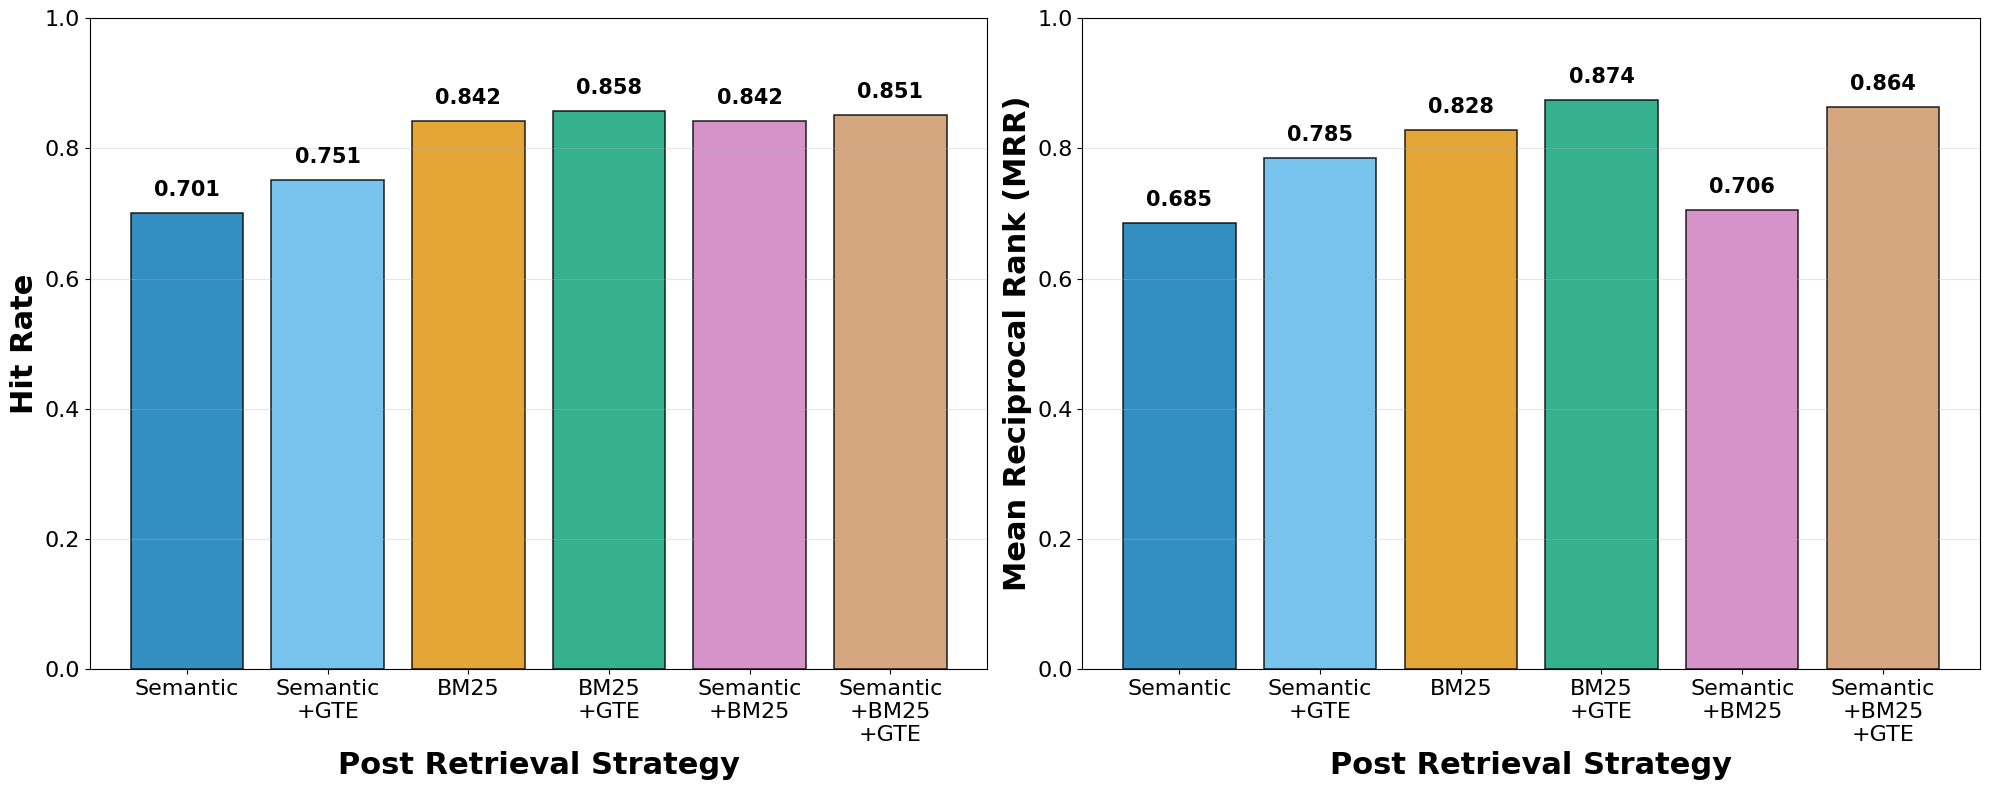

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_palette("colorblind")

strategies = [
    'Semantic',
    'Semantic\n+GTE',
    'BM25',
    'BM25\n+GTE',
    'Semantic\n+BM25',
    'Semantic\n+BM25\n+GTE'
    # 'Semantic\n+BM25\n+RRF',
    # 'Semantic\n+BM25\n+RRF+GTE'
]

hit_rates = [0.7012, 0.7510, 0.8423, 0.8575, 0.8423, 0.8506] #0.5035, 0.5035]
mrr_scores = [0.6850, 0.7847, 0.8281, 0.8742, 0.7055, 0.8639] #0.4832, 0.4832]

colors = ['#0173B2', '#56B4E9', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

bars1 = ax1.bar(strategies, hit_rates, color=colors, edgecolor='black', linewidth=1.2, alpha=0.8)
ax1.set_ylabel('Hit Rate', fontsize=22, fontweight='bold')
ax1.set_xlabel('Post Retrieval Strategy', fontsize=22, fontweight='bold')
ax1.set_ylim(0, 1.0)
# ax1.axhline(y=max(hit_rates), color='gray', linestyle='--', alpha=0.9, linewidth=2)
# ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=15, fontweight='bold')

bars2 = ax2.bar(strategies, mrr_scores, color=colors, edgecolor='black', linewidth=1.2, alpha=0.8)
ax2.set_ylabel('Mean Reciprocal Rank (MRR)', fontsize=22, fontweight='bold')
ax2.set_xlabel('Post Retrieval Strategy', fontsize=22, fontweight='bold')
ax2.set_ylim(0, 1.0)
# ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
# ax2.axhline(y=max(mrr_scores), color='gray', linestyle='--', alpha=0.9, linewidth=2)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.savefig('retrieval_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plt.tight_layout()
plt.savefig('retrieval_comparison_combined.png', dpi=300, bbox_inches='tight')
plt.show()

**Why Semantic when BM25 outperforms?**

Synthetic Eval Dataset Limiations:
  - Self containment
  - Patternless words such as author names
  - Keyword specific Vs Meaning specific (E.g, Using synonyms)
